In [1]:
import sys, os; sys.path.append(os.path.dirname(os.getcwd()))
import pickle 
import numpy as np
import pandas as pd
from pyfrechet.metric_spaces import MetricData, Sphere

import matplotlib.pyplot as plt
import seaborn as sns

import geomstats.visualization as visualization

INFO: Using numpy backend


In [2]:
coverages=[]
alpha=0.05
M=Sphere(2)

for file in os.listdir(os.path.join(os.getcwd(), 'results')):
    infile=open(os.path.join(os.getcwd(), 'results/'+file), 'rb')
    result=pickle.load(infile)

    Dalpha=np.percentile(result['oob_errors'], (1-alpha)*100)
    coverages.append(np.mean(M.d(result['test_predictions'].data, 
                                 result['y_test_data']) <= Dalpha))

    infile.close()


In [4]:
print(len(coverages))
print(np.mean(coverages))

3000
0.9465533333333332


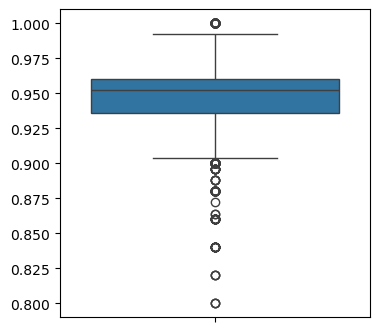

In [3]:
plt.figure(figsize=(4,4))
sns.boxplot(coverages)
plt.show()

In [4]:
results=[]

for file in os.listdir(os.path.join(os.getcwd(), 'results')):
    infile=open(os.path.join(os.getcwd(), 'results/'+file), 'rb')
    result=pickle.load(infile)

    results.append(result)

    infile.close()

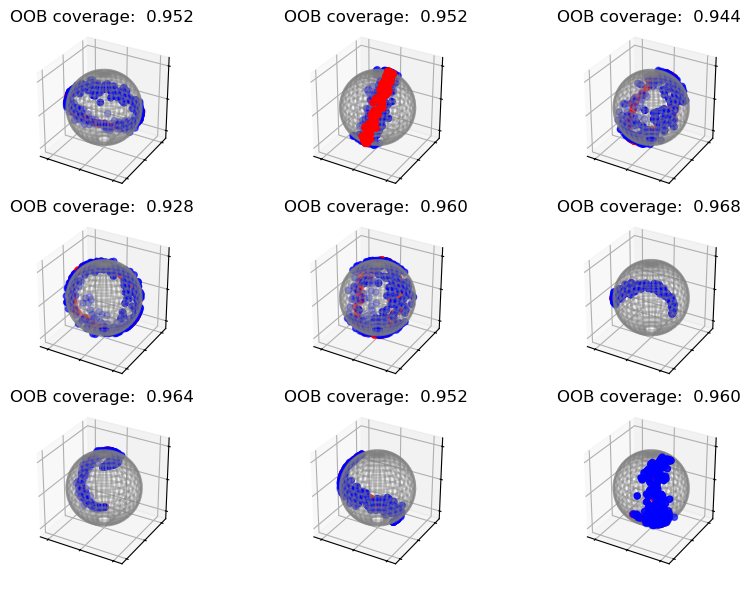

In [5]:
M=Sphere(2)
alpha=0.05
ncol=3
nrow=3

fig, axs =plt.subplots(nrow, ncol, subplot_kw={'projection': '3d'}, figsize=(10,7))
for i in range(nrow):
    for j in range(ncol):
        visualization.plot(results[ncol*i+j]['y_test_data'], space='S2', color='blue', ax=axs[i,j])
        visualization.plot(results[ncol*i+j]['test_predictions'], space='S2', color='red', ax=axs[i,j])
        axs[i,j].set_xlabel('')
        axs[i,j].set_ylabel('')
        axs[i,j].set_zlabel('')
        axs[i,j].set_xticklabels([])
        axs[i,j].set_yticklabels([])
        axs[i,j].set_zticklabels([])
        Dalpha=np.percentile(results[ncol*i+j]['oob_errors'], (1-alpha)*100)
        coverage=np.mean(M.d(results[ncol*i+j]['test_predictions'].data, 
                             results[ncol*i+j]['y_test_data']) <= Dalpha)
        axs[i,j].set_title(f'OOB coverage: {coverage: .3f}')    

# plt.tight_layout()
plt.show()

In [6]:
# For to create the grid for the sphere
def create_S2_grid(grid_size: int=200) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    u = np.linspace(0, 2 * np.pi, grid_size, endpoint=False)
    v = np.linspace(0, np.pi, grid_size//2)
    x_grid = np.outer(np.cos(u), np.sin(v))
    y_grid = np.outer(np.sin(u), np.sin(v))
    z_grid = np.outer(np.ones(np.size(u)), np.cos(v))
    return (x_grid, y_grid, z_grid)

# Function to plot the prediction ball for given indices_to_plot list of indices
def plot_OOB_balls(grid: tuple[np.ndarray, np.ndarray, np.ndarray],
                   predictions: np.ndarray,
                   indices_to_plot: list[int],
                   Dalpha: float,
                   ax,
                   color='deepskyblue',
                   alpha=0.1) -> None:
    
    for index_to_plot in indices_to_plot:
        ax.scatter3D(predictions[index_to_plot,0],
                predictions[index_to_plot,1],
                predictions[index_to_plot,2], marker='x', color='red', s=30, alpha=1)
        
        for i in range(grid[2].shape[0]):
            for j in range(grid[2].shape[1]):
                if M.d(predictions[index_to_plot,:], np.array([grid[0][i,j], grid[1][i,j], grid[2][i,j]])) <= Dalpha:
                    ax.scatter3D(grid[0][i,j], grid[1][i,j], grid[2][i,j], color=color, alpha=alpha)    


In [7]:
x_grid, y_grid, z_grid=create_S2_grid()

# Plot random forest predictions
fig=plt.figure(figsize=(12,7))
ax=plt.axes(projection='3d')
ax.plot_surface(x_grid, y_grid, z_grid, color='green', alpha=0.05)
ax.plot_wireframe(x_grid, y_grid, z_grid, color='green', alpha=0.1)

# Plot OOB balls
plot_OOB_balls((x_grid, y_grid, z_grid), 
               predictions=results[17]['test_predictions'], 
               indices_to_plot=range(0,50,10), 
               Dalpha=np.percentile(results[17]['oob_errors'], (1-0.05)*100), 
               ax=ax)

ax.set_title('Prediction ball of a particular observation')
ax.view_init(elev=15, azim=90)
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x000002B60CA6A040> (for post_execute):


AttributeError: 'PathCollection' object has no attribute 'do_3d_projection'

AttributeError: 'PathCollection' object has no attribute 'do_3d_projection'

<Figure size 1200x700 with 1 Axes>

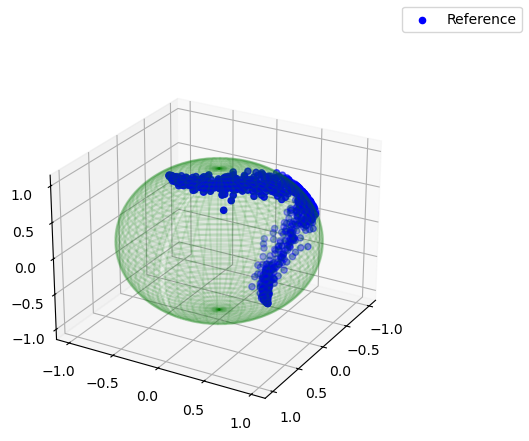

In [8]:
# For plotting the sphere
x_grid, y_grid, z_grid = create_S2_grid(grid_size=100)

# Plot random forest predictions
#forest_predictions_cartesian = Hypersphere(dim=2).spherical_to_extrinsic(forest_predictions.data)
fig=plt.figure()
ax=plt.axes(projection='3d')
ax.scatter3D(results[6]['y_train_data'][:,0],
            results[6]['y_train_data'][:,1],
            results[6]['y_train_data'][:,2], color='blue', label='Reference')
ax.plot_surface(x_grid, y_grid, z_grid, color='green', alpha=0.05)
ax.plot_wireframe(x_grid, y_grid, z_grid, color='green', alpha=0.1)
ax.view_init(elev=25, azim=30)
fig.legend()

plt.show()

## Coverages analysis

In [20]:
sigmas=[0.1, 0.15, 0.2, 0.25, 0.3]

def coverage_results(sigmas: list, sign_level: float=0.05) -> pd.DataFrame:
    
    coverage_df=pd.DataFrame(columns=['sample_index', 'sample_size', 'spiral', 'sigma', 'coverage', 'OOB_quantile'])

    for file in os.listdir(os.path.join(os.getcwd(), 'results')):
        infile=open(os.path.join(os.getcwd(), 'results/'+file), 'rb')
        result=pickle.load(infile)
        infile.close()

        Dalpha=np.percentile(result['oob_errors'], (1-sign_level)*100)
        coverage_df=pd.concat([coverage_df, 
                               pd.DataFrame({'sample_index': int(file.split('_')[1][4:]),
                                             'sample_size': int(file.split('_')[2][1:]),
                                             'spiral': file.split('_')[3][6:],
                                             'sigma': sigmas[int(file.split('_')[4][5:])-1],
                                             'coverage': np.mean(M.d(result['test_predictions'], result['y_test_data']) <= Dalpha),
                                             'OOB_quantile': Dalpha}, index=pd.RangeIndex(0,1))], 
                                ignore_index=True)
        
    coverage_df['sample_size']=coverage_df['sample_size'].astype('int')
    coverage_df['sample_index']=coverage_df['sample_index'].astype('int')
        
    return coverage_df

sign_level=0.05
coverage_df=coverage_results(sigmas=sigmas, sign_level=sign_level)
print(coverage_df.info())
coverage_df

C:\Users\J2404\AppData\Local\Temp\ipykernel_1760\1093712097.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  coverage_df=pd.concat([coverage_df,


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sample_index  3000 non-null   int32  
 1   sample_size   3000 non-null   int32  
 2   spiral        3000 non-null   object 
 3   sigma         3000 non-null   float64
 4   coverage      3000 non-null   float64
 5   OOB_quantile  3000 non-null   float64
dtypes: float64(3), int32(2), object(1)
memory usage: 117.3+ KB
None


,sample_index,sample_size,spiral,sigma,coverage,OOB_quantile
0,100,1000,0,0.10,0.952,0.203023
1,100,1000,0,0.15,0.952,0.303475
2,100,1000,0,0.20,0.944,0.387855
3,100,1000,0,0.25,0.928,0.534901
4,100,1000,0,0.30,0.960,0.590516
...,...,...,...,...,...,...
2995,9,500,1,0.10,0.976,0.172343
2996,9,500,1,0.15,0.976,0.230268
2997,9,500,1,0.20,1.000,0.312529
2998,9,500,1,0.25,0.968,0.439630


In [28]:
for x in coverage_df['sample_size'].unique():
    print(coverage_df.loc[coverage_df.sample_size==x])

      sample_index  sample_size spiral  sigma  coverage  OOB_quantile
0              100         1000      0   0.10     0.952      0.203023
1              100         1000      0   0.15     0.952      0.303475
2              100         1000      0   0.20     0.944      0.387855
3              100         1000      0   0.25     0.928      0.534901
4              100         1000      0   0.30     0.960      0.590516
...            ...          ...    ...    ...       ...           ...
2975             9         1000      1   0.10     0.960      0.167202
2976             9         1000      1   0.15     0.976      0.240759
2977             9         1000      1   0.20     0.964      0.323627
2978             9         1000      1   0.25     0.944      0.389788
2979             9         1000      1   0.30     0.940      0.462672

[1000 rows x 6 columns]
      sample_index  sample_size spiral  sigma  coverage  OOB_quantile
10             100          200      0   0.10      0.98      0.26

INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\J2404\AppData\Local\Temp\ipykernel_1760\4089179965.py:4: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.boxplot(data=coverage_df, x='sample_size', y='coverage', hue='sample_size', palette=sns.color_palette())
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


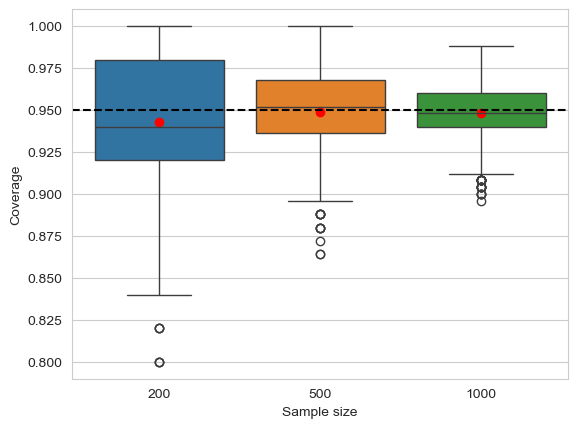

In [48]:
sns.set_style("whitegrid")

plt.figure()
sns.boxplot(data=coverage_df, x='sample_size', y='coverage', hue='sample_size', palette=sns.color_palette())
x_ticks, _=plt.xticks()
for i in range(len(x_ticks)):
    mean=coverage_df[coverage_df.sample_size==sorted(coverage_df['sample_size'].unique())[i]]['coverage'].mean()
    plt.plot(x_ticks[i], mean, marker='o', color='red')

plt.axhline(y=1-sign_level, color='black', linestyle='dashed')
plt.legend().remove()
#plt.title('Coverages vs. sample size')
plt.xlabel('Sample size')
plt.ylabel('Coverage')
plt.show()

In [42]:
sorted(coverage_df['sample_size'].unique())

[200, 500, 1000]

INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\J2404\AppData\Local\Temp\ipykernel_1760\2561948410.py:2: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.boxplot(data=coverage_df[coverage_df.spiral=='0'], x='sample_size', y='coverage',
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\J2404\AppData\Local\Temp\ipykernel_1760\2561948410.py:7: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  

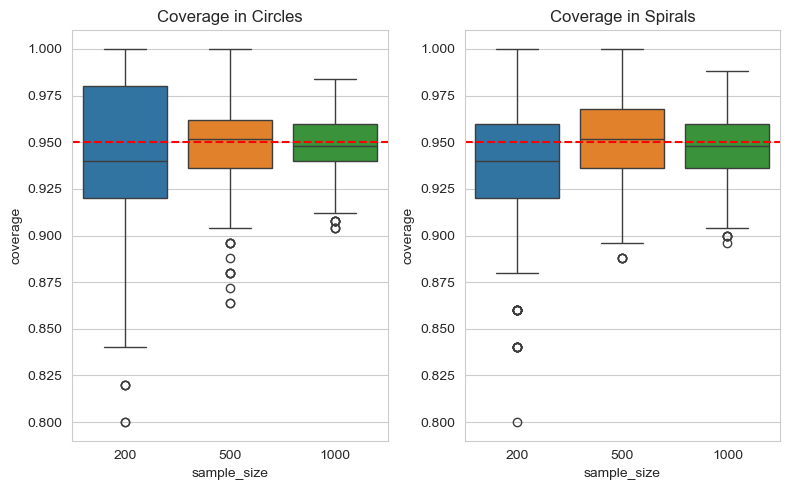

In [11]:
fig, axs=plt.subplots(1,2, figsize=(8,5))
sns.boxplot(data=coverage_df[coverage_df.spiral=='0'], x='sample_size', y='coverage', 
            hue='sample_size', palette=sns.color_palette(), ax=axs[0])
axs[0].set_title('Coverage in Circles')
axs[0].axhline(y=1-sign_level, color='red', linestyle='dashed')
axs[0].legend().remove()
sns.boxplot(data=coverage_df[coverage_df.spiral=='1'], x='sample_size', y='coverage', 
            hue='sample_size', palette=sns.color_palette(), ax=axs[1])
axs[1].set_title('Coverage in Spirals')
axs[1].axhline(y=1-sign_level, color='red', linestyle='dashed')
axs[1].legend().remove()

plt.tight_layout()
plt.show()

INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\J2404\AppData\Local\Temp\ipykernel_1760\2189548975.py:2: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.boxplot(data=coverage_df, x='sigma', y='coverage', hue='sample_size', palette=sns.color_palette())
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


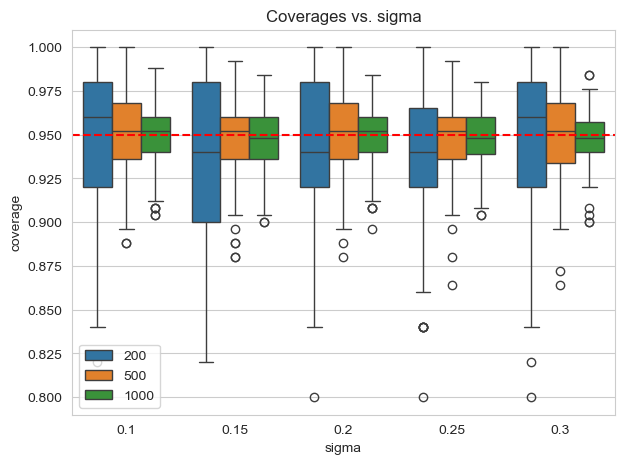

In [12]:
plt.figure(figsize=(7,5))
sns.boxplot(data=coverage_df, x='sigma', y='coverage', hue='sample_size', palette=sns.color_palette())
plt.title('Coverages vs. sigma')
plt.axhline(y=1-sign_level, color='red', linestyle='dashed')
plt.legend()#.remove()
plt.show()

INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\J2404\AppData\Local\Temp\ipykernel_1760\1853839560.py:2: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.boxplot(data=coverage_df, x='sigma', y='OOB_quantile', hue='sample_size', palette=sns.color_palette())
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


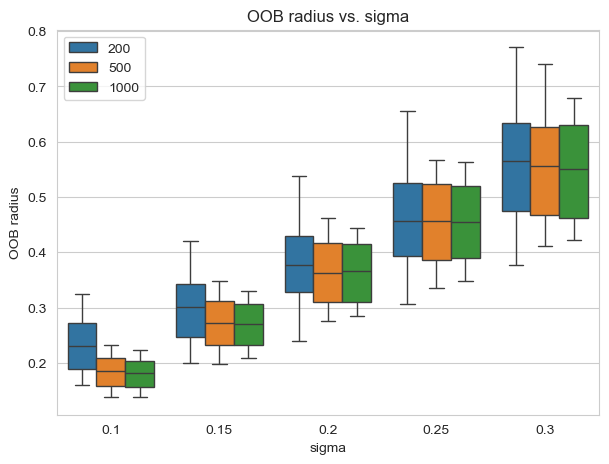

In [13]:
plt.figure(figsize=(7,5))
sns.boxplot(data=coverage_df, x='sigma', y='OOB_quantile', hue='sample_size', palette=sns.color_palette())
plt.title('OOB radius vs. sigma')
plt.ylabel('OOB radius')
plt.legend()#.remove()
plt.show()

In [14]:
sigmas=[0.1, 0.15, 0.2, 0.25, 0.3]

def coverage_results(sigmas: list, sign_level: float=0.05, 
                     regularize_test_size: bool=False, test_size: int=50,
                     random_state: int=42) -> pd.DataFrame:
    
    coverage_df=pd.DataFrame(columns=['sample_index', 'sample_size', 'spiral', 'sigma', 'coverage', 'OOB_quantile'])

    if regularize_test_size:
        np.random.seed(random_state)
        for file in os.listdir(os.path.join(os.getcwd(), 'results')):
            infile=open(os.path.join(os.getcwd(), 'results/'+file), 'rb')
            result=pickle.load(infile)
            infile.close()

            mask=np.random.randint(low=0, high=result['test_predictions'].shape[0], size=test_size)
            result['test_predictions']=result['test_predictions'][mask,:]
            result['oob_errors']=result['oob_errors'][mask]
            result['y_test_data']=result['y_test_data'][mask]

            Dalpha=np.percentile(result['oob_errors'], (1-sign_level)*100)
            coverage_df=pd.concat([coverage_df, 
                                pd.DataFrame({'sample_index': int(file.split('_')[1][4:]),
                                                'sample_size': int(file.split('_')[2][1:]),
                                                'spiral': file.split('_')[3][6:],
                                                'sigma': sigmas[int(file.split('_')[4][5:])-1],
                                                'coverage': np.mean(M.d(result['test_predictions'], result['y_test_data']) <= Dalpha),
                                                'OOB_quantile': Dalpha}, index=pd.RangeIndex(0,1))], 
                                    ignore_index=True)

    else:
        for file in os.listdir(os.path.join(os.getcwd(), 'results')):
            infile=open(os.path.join(os.getcwd(), 'results/'+file), 'rb')
            result=pickle.load(infile)
            infile.close()

            Dalpha=np.percentile(result['oob_errors'], (1-sign_level)*100)
            coverage_df=pd.concat([coverage_df, 
                                pd.DataFrame({'sample_index': int(file.split('_')[1][4:]),
                                                'sample_size': int(file.split('_')[2][1:]),
                                                'spiral': file.split('_')[3][6:],
                                                'sigma': sigmas[int(file.split('_')[4][5:])-1],
                                                'coverage': np.mean(M.d(result['test_predictions'], result['y_test_data']) <= Dalpha),
                                                'OOB_quantile': Dalpha}, index=pd.RangeIndex(0,1))], 
                                    ignore_index=True)
        
    coverage_df['sample_size']=coverage_df['sample_size'].astype('int')
    coverage_df['sample_index']=coverage_df['sample_index'].astype('int')
        
    return coverage_df

sign_level=0.05
coverage_df=coverage_results(sigmas=sigmas, sign_level=sign_level, regularize_test_size=True, test_size=50)
print(coverage_df.info())
coverage_df

C:\Users\J2404\AppData\Local\Temp\ipykernel_1760\3162825784.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  coverage_df=pd.concat([coverage_df,


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sample_index  3000 non-null   int32  
 1   sample_size   3000 non-null   int32  
 2   spiral        3000 non-null   object 
 3   sigma         3000 non-null   float64
 4   coverage      3000 non-null   float64
 5   OOB_quantile  3000 non-null   float64
dtypes: float64(3), int32(2), object(1)
memory usage: 117.3+ KB
None


,sample_index,sample_size,spiral,sigma,coverage,OOB_quantile
0,100,1000,0,0.10,0.98,0.219709
1,100,1000,0,0.15,0.94,0.245627
2,100,1000,0,0.20,0.92,0.345545
3,100,1000,0,0.25,0.98,0.625044
4,100,1000,0,0.30,0.98,0.703517
...,...,...,...,...,...,...
2995,9,500,1,0.10,0.98,0.181968
2996,9,500,1,0.15,0.88,0.196188
2997,9,500,1,0.20,0.98,0.284550
2998,9,500,1,0.25,0.94,0.367471


INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\J2404\AppData\Local\Temp\ipykernel_1760\2195960152.py:4: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.boxplot(data=coverage_df, x='sample_size', y='coverage', hue='sample_size', palette=sns.color_palette())
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


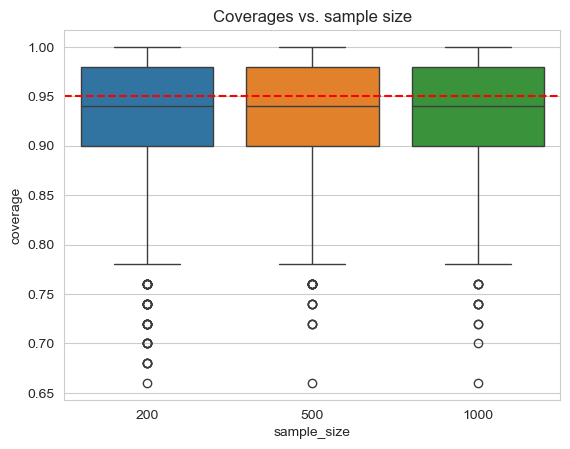

In [15]:
sns.set_style("whitegrid")

plt.figure()
sns.boxplot(data=coverage_df, x='sample_size', y='coverage', hue='sample_size', palette=sns.color_palette())
plt.axhline(y=1-sign_level, color='red', linestyle='dashed')
plt.legend().remove()
plt.title('Coverages vs. sample size')
plt.show()

INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\J2404\AppData\Local\Temp\ipykernel_1760\2561948410.py:2: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.boxplot(data=coverage_df[coverage_df.spiral=='0'], x='sample_size', y='coverage',
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\J2404\AppData\Local\Temp\ipykernel_1760\2561948410.py:7: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  

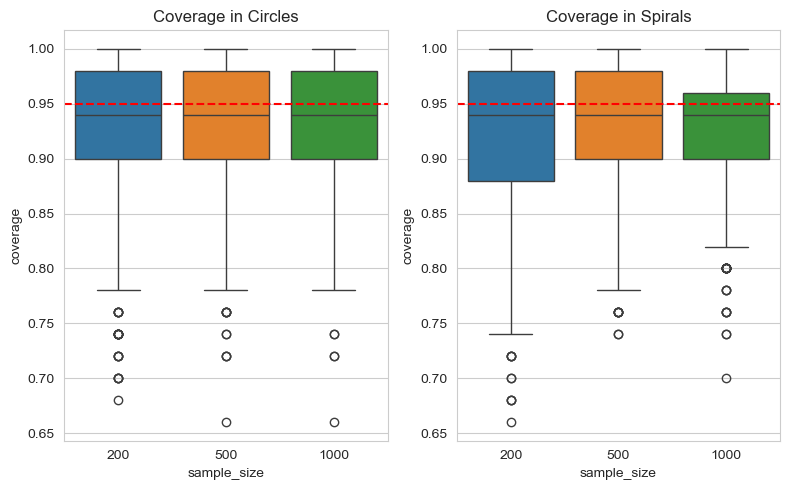

In [16]:
fig, axs=plt.subplots(1,2, figsize=(8,5))
sns.boxplot(data=coverage_df[coverage_df.spiral=='0'], x='sample_size', y='coverage', 
            hue='sample_size', palette=sns.color_palette(), ax=axs[0])
axs[0].set_title('Coverage in Circles')
axs[0].axhline(y=1-sign_level, color='red', linestyle='dashed')
axs[0].legend().remove()
sns.boxplot(data=coverage_df[coverage_df.spiral=='1'], x='sample_size', y='coverage', 
            hue='sample_size', palette=sns.color_palette(), ax=axs[1])
axs[1].set_title('Coverage in Spirals')
axs[1].axhline(y=1-sign_level, color='red', linestyle='dashed')
axs[1].legend().remove()

plt.tight_layout()
plt.show()

INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\J2404\AppData\Local\Temp\ipykernel_1760\2189548975.py:2: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.boxplot(data=coverage_df, x='sigma', y='coverage', hue='sample_size', palette=sns.color_palette())
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


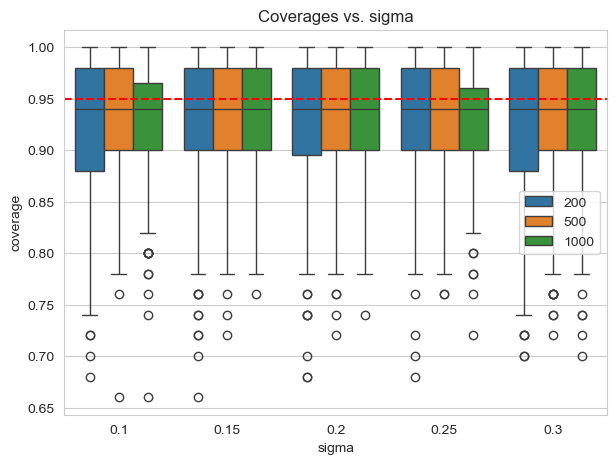

In [17]:
plt.figure(figsize=(7,5))
sns.boxplot(data=coverage_df, x='sigma', y='coverage', hue='sample_size', palette=sns.color_palette())
plt.title('Coverages vs. sigma')
plt.axhline(y=1-sign_level, color='red', linestyle='dashed')
plt.legend()#.remove()
plt.show()

INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\J2404\AppData\Local\Temp\ipykernel_1760\1853839560.py:2: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.boxplot(data=coverage_df, x='sigma', y='OOB_quantile', hue='sample_size', palette=sns.color_palette())
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


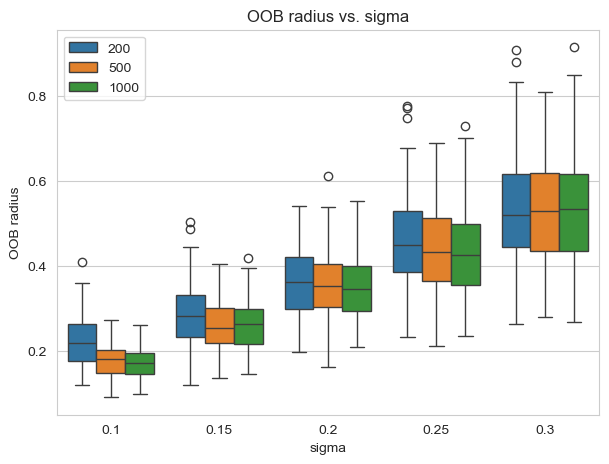

In [18]:
plt.figure(figsize=(7,5))
sns.boxplot(data=coverage_df, x='sigma', y='OOB_quantile', hue='sample_size', palette=sns.color_palette())
plt.title('OOB radius vs. sigma')
plt.ylabel('OOB radius')
plt.legend()#.remove()
plt.show()